In [1]:
!gsutil cp gs://rebecca-summer23/cd138_adata_MOREHVG_noIG.h5ad /tmp

Copying gs://rebecca-summer23/cd138_adata_MOREHVG_noIG.h5ad...
/ [1 files][  3.5 GiB/  3.5 GiB]   80.2 MiB/s                                   
Operation completed over 1 objects/3.5 GiB.                                      


In [2]:
import mrvi
import anndata
import scanpy as sc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.cluster import DBSCAN

/home/boiarskr/anaconda3/envs/mrvi/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/boiarskr/anaconda3/envs/mrvi/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/boiarskr/anaconda3/envs/mrvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
torch.cuda.is_available()

True

## load Boiarsky et al MM data

In [4]:
cd138_adata = sc.read_h5ad("/tmp/cd138_adata_MOREHVG_noIG.h5ad")

## cluster CNVs and add to anndata

In [5]:
# read in pickled results
!gsutil cp gs://rebecca-summer23/outputs/cnv_array_cd138.pkl /tmp

Copying gs://rebecca-summer23/outputs/cnv_array_cd138.pkl...
\ [1 files][  4.9 GiB/  4.9 GiB]   83.6 MiB/s                                   
Operation completed over 1 objects/4.9 GiB.                                      


In [5]:
file = open('/tmp/cnv_array_cd138.pkl', 'rb')

# dump information to that file
cnv_array = pickle.load(file)

# close the file
file.close()

In [6]:
cnv_df = pd.DataFrame(cnv_array, index=cd138_adata.obs.index, columns = cd138_adata.var.index)

In [7]:
cnv_unique = cnv_df.merge(cd138_adata.obs[['person']], right_index=True, left_index=True)

In [8]:
cnv_unique = cnv_unique.drop_duplicates("person").set_index("person")

In [9]:
cnv_dense = cnv_unique.loc[:,cnv_unique.sum(axis=0)!=35]
cnv_dense.shape

(35, 3922)

# how much does this overlap with HVG? not very much - yikes! if <1% of the CNV genes are present in the input to MRVI, then it can only incorrectly correct it

In [11]:
cnv_dense.columns.isin(cd138_adata.var.index[cd138_adata.var.highly_variable]).sum()

366

In [15]:
366/3922

0.09331973482916879

In [16]:
cd138_adata.var.highly_variable.sum()

1393

#### cluster the data based on the genes with CNVs

In [10]:
clustering = DBSCAN(eps=3, min_samples=2).fit(cnv_dense)

In [11]:
cd138_adata.obs = cd138_adata.obs.merge(pd.DataFrame({'person':cnv_dense.index, 'cnv_cluster':clustering.labels_}))

<Axes: xlabel='cnv_cluster', ylabel='sample_purity'>

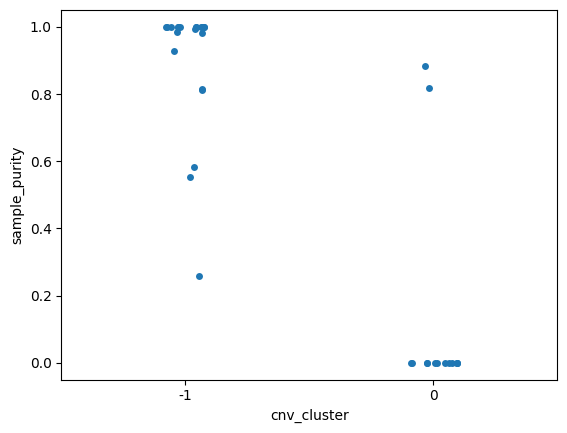

In [14]:
sns.stripplot(cd138_adata.obs[["person","cnv_cluster","sample_purity"]].drop_duplicates(), x="cnv_cluster", y="sample_purity")

# Train mrVI with these two clusters

In [14]:
cd138_adata_hvg = cd138_adata[:,cd138_adata.var.highly_variable].copy()

/home/boiarskr/anaconda3/envs/mrvi/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [15]:
mrvi.MrVI.setup_anndata(cd138_adata_hvg, layer="counts", sample_key="cnv_cluster")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [16]:
mrvi_model = mrvi.MrVI(cd138_adata_hvg)

In [17]:
mrvi_model.train(plan_kwargs={'lr':1e-4}, max_epochs=400)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [13:52<00:00,  2.10s/it, v_num=1, train_loss_step=762, train_loss_epoch=885]        

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [13:52<00:00,  2.08s/it, v_num=1, train_loss_step=762, train_loss_epoch=885]


In [18]:
#pickle mrvi results
import pickle 

# open a file, where you ant to store the data
file = open('/tmp/mrvi_categoricalcnv_lre4_maxepochs400_cd138.pkl', 'wb')

# dump information to that file
pickle.dump(mrvi_model, file)

# close the file
file.close()

!gsutil cp /tmp/mrvi_categoricalcnv_lre4_maxepochs400_cd138.pkl gs://rebecca-summer23/outputs/mrvi_categoricalcnv_lre4_maxepochs400_cd138.pkl

Copying file:///tmp/mrvi_categoricalcnv_lre4_maxepochs400_cd138.pkl [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1 files][588.1 MiB/588.1 MiB]                                                
Operation completed over 1 objects/588.1 MiB.                                    


In [1]:
# copy saved model from bucket
!gsutil cp gs://rebecca-summer23/outputs/mrvi_categoricalcnv_cd138.pkl /tmp/

Copying gs://rebecca-summer23/outputs/mrvi_categoricalcnv_cd138.pkl...
\ [1 files][  3.5 GiB/  3.5 GiB]   72.3 MiB/s                                   
Operation completed over 1 objects/3.5 GiB.                                      


In [2]:
#load saved model
import pickle 

file = open('/tmp/mrvi_categoricalcnv_cd138.pkl', 'rb')

# dump information to that file
mrvi_model = pickle.load(file)

# close the file
file.close()

/home/boiarskr/anaconda3/envs/mrvi/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/boiarskr/anaconda3/envs/mrvi/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/boiarskr/anaconda3/envs/mrvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# how does loss behave over epochs?
mrvi_model.trainer.logger.history['validation_loss'].reset_index().rename(columns={"index":"epoch"})#.plot("epoch", "validation_loss")

,epoch,validation_loss
0,0,5946.196777
1,1,6435.668945
2,2,6580.715332
3,3,6585.575195
4,4,6592.420898
...,...,...
395,395,6001.844727
396,396,10414.370117
397,397,2416.205566
398,398,4644.786133


<Axes: xlabel='epoch'>

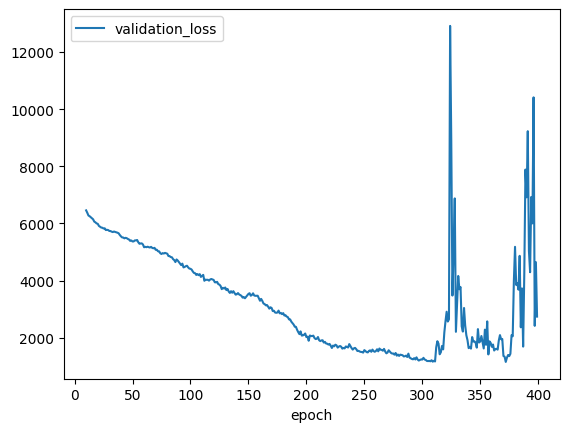

In [20]:
# how does loss behave over epochs?
mrvi_model.trainer.logger.history['validation_loss'].reset_index().rename(columns={"index":"epoch"}).iloc[10:].plot("epoch", "validation_loss")

<Axes: xlabel='epoch'>

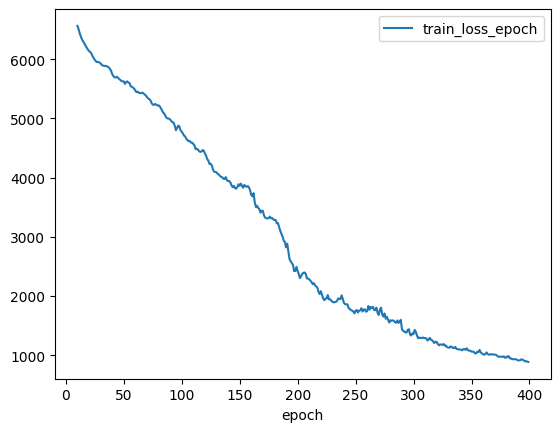

In [21]:
# how does loss behave over epochs?
mrvi_model.trainer.logger.history['train_loss_epoch'].reset_index().rename(columns={"index":"epoch"}).iloc[10:].plot("epoch", "train_loss_epoch")

## based on above plots, retrain to 300 epochs

In [22]:
mrvi_model = mrvi.MrVI(cd138_adata_hvg)

In [23]:
mrvi_model.train(plan_kwargs={'lr':1e-4}, max_epochs=300)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/300:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 161/300:  53%|█████▎    | 160/300 [05:37<04:57,  2.12s/it, v_num=1, train_loss_step=2.3e+3, train_loss_epoch=2.59e+3] 

In [ ]:
#pickle mrvi results
import pickle 

# open a file, where you ant to store the data
file = open('/tmp/mrvi_categoricalcnv_lre4_maxepochs300_cd138.pkl', 'wb')

# dump information to that file
pickle.dump(mrvi_model, file)

# close the file
file.close()

!gsutil cp /tmp/mrvi_categoricalcnv_lre4_maxepochs300_cd138.pkl gs://rebecca-summer23/outputs/mrvi_categoricalcnv_lre4_maxepochs300_cd138.pkl

Copying file:///tmp/mrvi_categoricalcnv_lre4_maxepochs400_cd138.pkl [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1 files][588.1 MiB/588.1 MiB]                                                
Operation completed over 1 objects/588.1 MiB.                                    


In [12]:
file = open('/tmp/mrvi_categoricalcnv_lre4_maxepochs300_cd138.pkl', 'rb')

# dump information to that file
mrvi_model = pickle.load(file)

# close the file
file.close()

In [13]:
# Get z representation
cd138_adata.obsm["X_mrvi_z"] = mrvi_model.get_latent_representation(give_z=True)
# Get u representation
cd138_adata.obsm["X_mrvi_u"] = mrvi_model.get_latent_representation(give_z=False)


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
100%|██████████| 230/230 [00:11<00:00, 19.46it/s]


In [14]:
sc.pp.neighbors(cd138_adata, use_rep="X_mrvi_z")
sc.tl.umap(cd138_adata)

/home/boiarskr/anaconda3/envs/mrvi/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/boiarskr/anaconda3/envs/mrvi/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/boiarskr/anaconda3/envs/mrvi/lib/python3.9/site-packages/umap/dist

/home/boiarskr/anaconda3/envs/mrvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


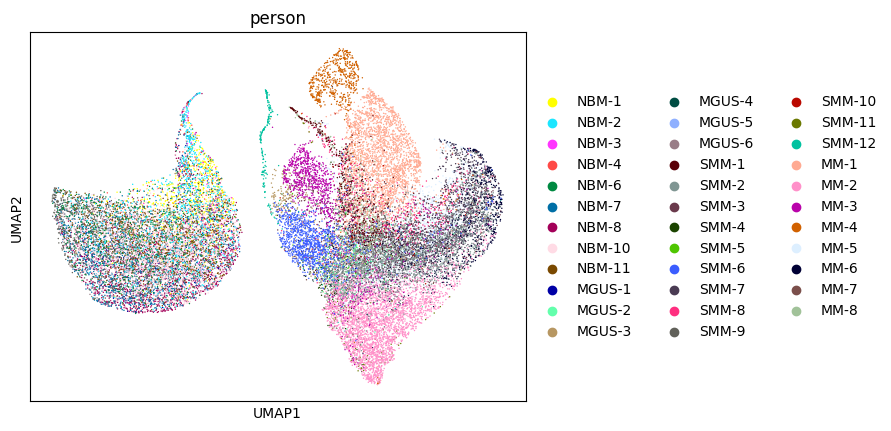

/home/boiarskr/anaconda3/envs/mrvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


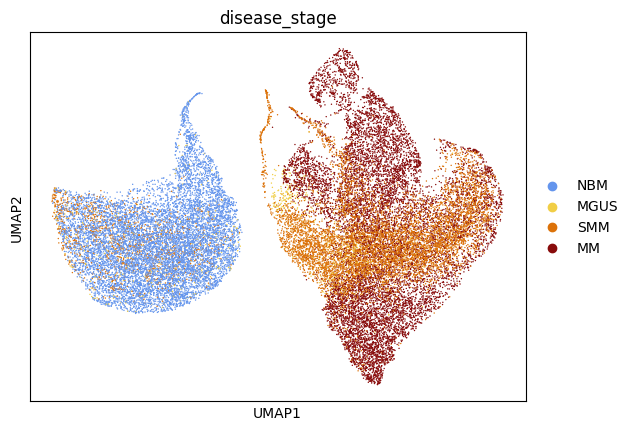

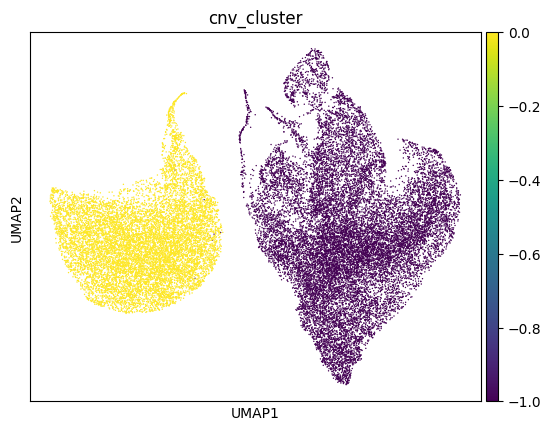

In [16]:
sc.pl.umap(cd138_adata, color="person")
sc.pl.umap(cd138_adata, color="disease_stage")
sc.pl.umap(cd138_adata, color="cnv_cluster")

/home/boiarskr/anaconda3/envs/mrvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


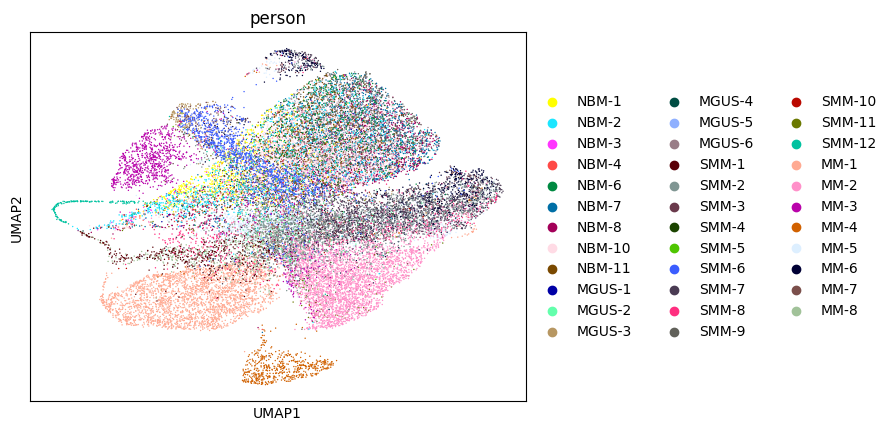

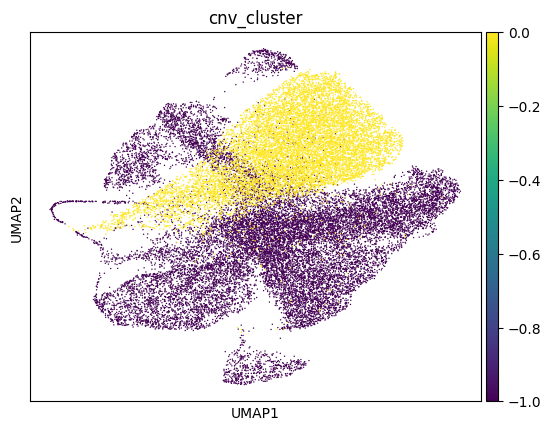

/home/boiarskr/anaconda3/envs/mrvi/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


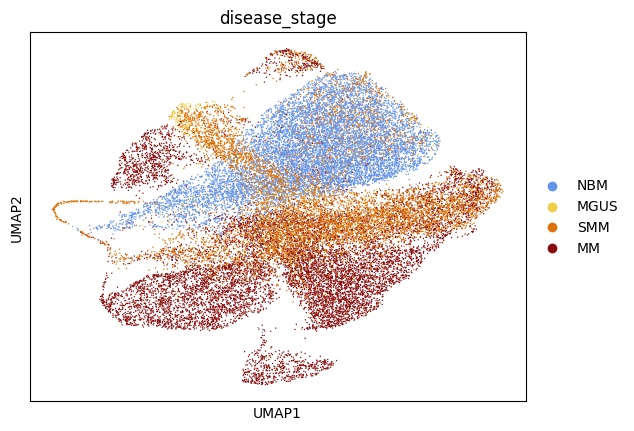

In [17]:
sc.pp.neighbors(cd138_adata, use_rep="X_mrvi_u")
sc.tl.umap(cd138_adata)
sc.pl.umap(cd138_adata, color="person")
sc.pl.umap(cd138_adata, color="cnv_cluster")
sc.pl.umap(cd138_adata, color="disease_stage")